In [1]:
_ = """
Desciption
- Visuelle products
- Not use of pytorch_forecasting
- year, month, day, dayofweek as positional embedding feature
- Extract attention from MY transformer but not from image model's
"""

# Configurations

### Import

In [1]:
import os
import joblib
import random
from IPython.display import clear_output

import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tslearn.utils import to_time_series_dataset

import torch
from PIL import Image
from torchvision import transforms
from transformers import SwinModel, SwinConfig, ViTModel, ViTConfig, Mask2FormerModel, Mask2FormerConfig
import matplotlib.cm as cm
import cv2

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [2]:
# Sampling parameter
n_smaples = None

# Data parameter
random_state = 0
pred_len = 30
batch_size = 32
valid_start_date = "2020-06-01"

# Model hyperparameter
d_model = 128; d_model = 256; d_model = 512
nhead = 4; nhead = 8
d_ff = 256; d_ff = 512; d_ff = 1024
dropout = 0.3; dropout = 0.3
num_layers = 4; num_layers = 6

# Seed set
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)

# Data

### Read

In [59]:
# Read transaction
df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
df_train_raw = df_trans[df_trans["t_dat"] < valid_start_date]
df_valid_raw = df_trans[df_trans["t_dat"] >= valid_start_date]

In [63]:
df_trans.groupby("customer_id").size().sort_values()

customer_id
ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241       1
73f988e71aa96456022c21f0fc62e78bcf7d97b5646b33883b231dd37d88204b       1
73f9a9dd9f5f3249685206fd12ac93b68c206a8c56fbd95eb767fa0dccde0892       1
11fa5af0b08a07eaf538044849db18130d706ca031a01c413af285e5e7b4d35b       1
73f9ca9e633c23ff9da2dbccbc687e092abdd375d4baa087209305378561f082       1
                                                                    ... 
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
Length: 1362281, dtype: int64

### Preprocess

In [5]:
def preprocess(data):
    data = data.copy()
    data = data.groupby(["article_id", "t_dat"], as_index=False).agg(sales=("customer_id","size"), price=("price","mean"))

    # Expand date
    def func(x):
        article_id = x["article_id"].iloc[0]
        max_date = x["t_dat"].max()
        y_start_date = max_date - pd.DateOffset(days=pred_len)
        dateref = pd.DataFrame(pd.date_range(y_start_date, max_date, freq="d"), columns=["t_dat"])
        x = pd.merge(dateref, x, on="t_dat", how="outer")
        x = x.sort_values("t_dat")
        x["sales"] = x["sales"].fillna(0)
        x["price"] = x["price"].fillna(method="ffill")
        x["article_id"] = article_id
        return x
    data = data.groupby("article_id", as_index=False).apply(lambda x: func(x)).reset_index(drop=True)

    # Make date positions
    data["year"] = data["t_dat"].dt.year
    data["month"] = data["t_dat"].dt.month - 1
    data["week"] = data["t_dat"].dt.isocalendar().week - 1
    data["day"] = data["t_dat"].dt.day -1
    data["dayofweek"] = data["t_dat"].dt.dayofweek
    
    # Aggregate with list
    data = data.groupby(["article_id"], as_index=False)[["sales", "price", "year", "month", "week", "day", "dayofweek"]].agg(lambda x: list(x))
    data["size"] = data["sales"].str.len()
    data = data[data["size"] > pred_len+1]

    # Read article info
    df_article = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
    df_article = df_article[["article_id"] + [col for col in df_article.columns if "name" in col]]

    # Merge two datasets
    df_raw = pd.merge(data, df_article, on="article_id")
    print(f"Original: {df_raw.shape}")

    # Filter valid length
    df_prep = df_raw.copy()
    df_prep = df_prep[df_prep["size"] > pred_len]
    print(f"Valid sized: {df_prep.shape}")

    # Sampling
    if n_smaples:
        samples = df_prep["article_id"].unique()
        df_prep = df_prep[df_prep["article_id"].isin(samples[:n_smaples])]
        print(f"{min(n_smaples, df_prep['article_id'].nunique())} sampled: {df_prep.shape}")

    # Encode imgpath
    encoder = LabelEncoder()
    df_prep["img_path"] = df_prep["article_id"].apply(lambda x: f'../HnM/images/{x[:3]}/{x}.jpg') # Generate image path
    df_prep["is_valid"] = df_prep["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    df_prep = df_prep[df_prep["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image
    print(f"Valid imaged:", df_prep.shape)

    return df_prep

In [6]:
df_train_prep = preprocess(df_train_raw); print("_"*100)
df_valid_prep = preprocess(df_valid_raw)

# Save
df_train_prep.to_parquet("df_train_prep.parquet")
df_valid_prep.to_parquet("df_valid_prep.parquet")

Original: (83078, 21)
Valid sized: (83078, 21)
Valid imaged: (82725, 22)
____________________________________________________________________________________________________
Original: (31030, 21)
Valid sized: (31030, 21)
Valid imaged: (30984, 22)


### Dataset

In [3]:
df_train_prep = pd.read_parquet("df_train_prep.parquet")
df_valid_prep = pd.read_parquet("df_valid_prep.parquet")

# df_train_prep = df_train_prep[~df_train_prep["product_type_name"].isin(exclude_li)]
# df_valid_prep = df_valid_prep[~df_valid_prep["product_type_name"].isin(exclude_li)]

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.sales = data["sales"].values
        self.img = data["img_path"].values
        self.year = data["year"].values
        self.month = data["month"].values
        self.week = data["week"].values
        self.day = data["day"].values
        self.dayofweek = data["dayofweek"].values
    
    def __getitem__(self, idx):
        sales_raw = self.sales[idx]
        
        # Scaling
        # scaler = MinMaxScaler()
        # sales_raw = scaler.fit_transform(sales_raw.reshape(-1,1)).reshape(-1) + 1
        sales_raw = np.log1p(sales_raw)

        # Process features
        sales = sales_raw[:-pred_len]
        y = sales_raw[-pred_len:]

        img = Image.open(self.img[idx]).convert("RGB")
        img_tensor = self.transform(img).numpy()

        year = self.year[idx][:-pred_len]
        month = self.month[idx][:-pred_len]
        week = self.week[idx][:-pred_len]
        day = self.day[idx][:-pred_len]
        dayofweek = self.dayofweek[idx][:-pred_len]        

        return sales, img, img_tensor, year, month, week, day, dayofweek, y

    def __len__(self):
        return self.img.shape[0]

train_dataset = Dataset(df_train_prep)
valid_dataset = Dataset(df_valid_prep)

def func(data):
    sales = np.nan_to_num(to_time_series_dataset([sales_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()

    img = ([img_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data])
    img_tensor = np.array([img_tensor_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data])

    year = np.nan_to_num(to_time_series_dataset([year_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    month = np.nan_to_num(to_time_series_dataset([month_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    week = np.nan_to_num(to_time_series_dataset([week_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    day = np.nan_to_num(to_time_series_dataset([day_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    dayofweek = np.nan_to_num(to_time_series_dataset([dayofweek_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data]), nan=0).squeeze()
    
    y = np.array([y_ for sales_, img_, img_tensor_, year_, month_, week_, day_, dayofweek_, y_ in data])

    sales = torch.FloatTensor(sales).unsqueeze(-1)
    img_tensor = torch.FloatTensor(img_tensor)

    year = torch.FloatTensor(year).unsqueeze(-1)
    month = torch.IntTensor(month)
    week = torch.IntTensor(week)
    day = torch.IntTensor(day)
    dayofweek = torch.IntTensor(dayofweek)

    y = torch.FloatTensor(y)

    return sales, img, img_tensor, year, month, week, day, dayofweek, y

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=8, shuffle=True, collate_fn=func)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=8, prefetch_factor=8, collate_fn=func)

for sales, img, img_tensor, year, month, week, day, dayofweek, y in train_dataloader:
    print(sales.shape)
    print(img_tensor.shape)
    print(year.shape)
    print(month.shape)
    print(week.shape)
    print(day.shape)
    print(dayofweek.shape)
    print(y.shape)
    break

torch.Size([32, 573, 1])
torch.Size([32, 3, 224, 224])
torch.Size([32, 573, 1])
torch.Size([32, 573])
torch.Size([32, 573])
torch.Size([32, 573])
torch.Size([32, 573])
torch.Size([32, 30])


# Modeling

### Architecture

In [46]:
import torch.nn.functional as F

verbose = False

class Mask(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def get_padding_mask(self, arr):
        res = torch.eq(arr, 0).type(torch.FloatTensor)
        res = torch.where(res==1, True, False)
        return res
    
    def get_lookahead_mask(self, arr):
        seq_len = arr.shape[1]
        mask = torch.triu(torch.ones((seq_len, seq_len))*-torch.inf, 1)
        return mask

    def forward(self, arr):
        padding_mask = self.get_padding_mask(arr)
        lookahead_mask = self.get_lookahead_mask(arr)
        return padding_mask.to(device), lookahead_mask.to(device)

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        # Raw embedder
        self.year_embedder = torch.nn.Linear(1, d_model)
        self.month_embedder = torch.nn.Embedding(num_embeddings=12, embedding_dim=d_model)
        
        # Concatenate
        self.layer_norm1 = torch.nn.LayerNorm(d_model*2)
        self.linear1 = torch.nn.Linear(d_model*2, d_model)

        # Feed forward concatenated positions
        self.linear2 = torch.nn.Linear(d_model, d_model)
        self.activation1 = torch.nn.ELU()
        self.linear3 = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)

        # Residual
        self.layer_norm2 = torch.nn.LayerNorm(d_model)

    def forward(self, year, month):
        # Raw embedder
        year_embedding = self.year_embedder(year)
        month_embedding = self.month_embedder(month)

        # Concatenate
        concat = torch.concat([year_embedding, month_embedding], dim=-1)
        concat = self.linear1(self.layer_norm1(concat))

        # Feed forward
        linear = self.activation1(self.linear2(concat))
        linear = self.dropout(self.linear3(linear))

        # Residual
        output = self.layer_norm2(concat + linear)

        return output

class CustomEncoderLayer(torch.nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, d_ff, dropout, batch_first):
        super().__init__(d_model, nhead, d_ff, dropout, batch_first=True)
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(src_mask),
            other_name="src_mask",
            target_type=src.dtype
        )

        src_mask = F._canonical_mask(
            mask=src_mask,
            mask_name="src_mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf
        why_not_sparsity_fast_path = ''
        if not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif self.training:
            why_not_sparsity_fast_path = "training is enabled"
        elif not self.self_attn.batch_first :
            why_not_sparsity_fast_path = "self_attn.batch_first was not True"
        elif not self.self_attn._qkv_same_embed_dim :
            why_not_sparsity_fast_path = "self_attn._qkv_same_embed_dim was not True"
        elif not self.activation_relu_or_gelu:
            why_not_sparsity_fast_path = "activation_relu_or_gelu was not True"
        elif not (self.norm1.eps == self.norm2.eps):
            why_not_sparsity_fast_path = "norm1.eps is not equal to norm2.eps"
        elif src.is_nested and (src_key_padding_mask is not None or src_mask is not None):
            why_not_sparsity_fast_path = "neither src_key_padding_mask nor src_mask are not supported with NestedTensor input"
        elif self.self_attn.num_heads % 2 == 1:
            why_not_sparsity_fast_path = "num_head is odd"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"
        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                self.self_attn.in_proj_weight,
                self.self_attn.in_proj_bias,
                self.self_attn.out_proj.weight,
                self.self_attn.out_proj.bias,
                self.norm1.weight,
                self.norm1.bias,
                self.norm2.weight,
                self.norm2.bias,
                self.linear1.weight,
                self.linear1.bias,
                self.linear2.weight,
                self.linear2.bias,
            )

            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            _supported_device_type = ["cpu", "cuda"]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif not all((x.device.type in _supported_device_type) for x in tensor_args):
                why_not_sparsity_fast_path = ("some Tensor argument's device is neither one of "
                                            f"{_supported_device_type}")
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                            "input/output projection weights or biases requires_grad")

            if not why_not_sparsity_fast_path:
                merged_mask, mask_type = self.self_attn.merge_masks(src_mask, src_key_padding_mask, src)
                return torch._transformer_encoder_layer_fwd(
                    src,
                    self.self_attn.embed_dim,
                    self.self_attn.num_heads,
                    self.self_attn.in_proj_weight,
                    self.self_attn.in_proj_bias,
                    self.self_attn.out_proj.weight,
                    self.self_attn.out_proj.bias,
                    self.activation_relu_or_gelu == 2,
                    self.norm_first,
                    self.norm1.eps,
                    self.norm1.weight,
                    self.norm1.bias,
                    self.norm2.weight,
                    self.norm2.bias,
                    self.linear1.weight,
                    self.linear1.bias,
                    self.linear2.weight,
                    self.linear2.bias,
                    merged_mask,
                    mask_type,
                )


        x = src
        print("x.shape", x.shape)
        print("src_key_padding_mask.shape", src_key_padding_mask.shape)
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), src_mask, src_key_padding_mask, is_causal=is_causal)
            x = x + self._ff_block(self.norm2(x))
        else:
            x = self.norm1(x + self._sa_block(x, src_mask, src_key_padding_mask, is_causal=is_causal))
            x = self.norm2(x + self._ff_block(x))
        print("x.shape", x.shape)
        return x

class Encoder(torch.nn.Module):
    def __init__(self, dropout, d_model, nhead, d_ff, num_layers):
        super().__init__()
        # Positional encoding
        self.sales_embedder = torch.nn.Linear(1, d_model)
        self.dropout = torch.nn.Dropout(dropout)

        # Encoding
        # self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
        self.encoder = torch.nn.TransformerEncoder(CustomEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
    
    def forward(self, sales, positional_embedding, enc_padding_mask):
        # Positional encoding
        sales_embedding = self.sales_embedder(sales)
        sales_embedding = self.dropout(sales_embedding + positional_embedding)

        # Encoding
        print("sales_embedding.shape", sales_embedding.shape)
        encoding = self.encoder(sales_embedding, src_key_padding_mask=enc_padding_mask)
        print("encoding.shape", encoding.shape)
        return encoding

class CustomDecoderLayer(torch.nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, d_ff, dropout, batch_first=True):
        super().__init__(d_model, nhead, d_ff, dropout, batch_first=True)
    
    def forward(self, tgt, memory, tgt_mask, memory_mask, tgt_key_padding_mask, memory_key_padding_mask, tgt_is_causal=False, memory_is_causal=False):
        x = tgt
        if self.norm_first:
            # sa_output, attn = self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask, tgt_is_causal)
            x = x
            attn_output = self._mha_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = x + attn_output
            x = x + self._ff_block(self.norm3(x))
        else:
            # sa_output, attn = self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask, tgt_is_causal)
            # x = self.norm1(x + sa_output)
            attn_output = self._mha_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = x + attn_output
            x = self.norm3(x + self._ff_block(x))

        return x
    
    # multihead attention block
    def _mha_block(self, x, mem, attn_mask, key_padding_mask, is_causal=False):
        # print("x.shape", x.shape)
        # print("mem.shape", mem.shape)
        # print("key_padding_mask.shape", key_padding_mask.shape)
        x = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=False)[0]
        # print(attn.sum(-1))
        return self.dropout2(x)

    # self-attention block
    def _sa_block(self, x, attn_mask, key_padding_mask, is_causal=False):
        x = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=False)[0]
        return self.dropout1(x)

class CustomDecoder(torch.nn.TransformerDecoder):
    def __init__(self, decoder_layer, num_layers, norm=None):
        super().__init__(decoder_layer, num_layers, norm)
    
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        output = tgt
        for mod in self.layers:
            output = mod(output, memory, tgt_mask=tgt_mask, memory_mask=memory_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)

        if self.norm:
            output = self.norm(output)
        
        return output

class Decoder(torch.nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout, num_layers):
        super().__init__()

        self.img_seq = 197 # Vit: 197, Swin: 49
        self.d_model = d_model

        # Image model train
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        # self.img_model = ViTModel(ViTConfig())
        # self.img_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
        # self.img_model = SwinModel(SwinConfig())
        # self.img_model = Mask2FormerModel.from_pretrained("facebook/mask2former-swin-small-coco-instance")
        # self.img_model = Mask2FormerModel(Mask2FormerConfig())
        
        # Image model embedding
        self.img_embedder = torch.nn.Linear(self.img_model.config.hidden_size, d_model)
        self.img_linear = torch.nn.Linear(d_model, d_model)
        self.img_activation = torch.nn.ELU()

        # Decoding
        self.decoder = CustomDecoder(CustomDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
        # self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
    
    def forward(self, img_tensor, encoder_output, enc_padding_mask):
        # Image embedding
        img_hidden_state, pooler_output, img_attn = self.img_model(img_tensor, output_attentions=True).values() # ViT, SwinTransformer
        # encoder_last_hidden_state, pixel_decoder_last_hidden_state, transformer_decoder_last_hidden_state, masks_queries_logits, attn_weight = self.img_model(pixel_values=img_tensor, pixel_mask=img_mask, output_attentions=True).values() # For Mask2Former
        img_embedding = self.img_activation(self.img_linear(self.img_embedder(img_hidden_state)))
        
        # print("img_embedding.shape", img_embedding.shape)
        # print("encoder_output.shape", encoder_output.shape)
        # print("enc_padding_mask.shape", enc_padding_mask.shape)
        dec_output = self.decoder(tgt=img_embedding, memory=encoder_output, memory_key_padding_mask=enc_padding_mask)
        return dec_output, img_attn

class Transformer(torch.nn.Module):
    def __init__(self, d_model, dropout, nhead, d_ff, num_layers, pred_len):
        super().__init__()
        # Post process
        self.enc_mask = Mask()
        self.positional_embedder = PositionalEmbedding(d_model, dropout)

        # Encoder-Decoder
        self.encoder = Encoder(dropout, d_model, nhead, d_ff, num_layers)
        self.decoder = Decoder(d_model, nhead, d_ff, dropout, num_layers)

        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(d_model, d_model)
        # self.linear1 = torch.nn.Linear(d_model*100, d_model)
        self.elu1 = torch.nn.ELU()
        
        self.linear2 = torch.nn.Linear(d_model, 1)

    def forward(self, sales, img_tensor, year, month, week, day, dayofweek):
        # Post process
        enc_padding_mask, _ = self.enc_mask(sales.squeeze(-1))
        positional_embedding = self.positional_embedder(year, month)

        encoder_output = self.encoder(sales, positional_embedding, enc_padding_mask)
        decoder_output, attn_li = self.decoder(img_tensor, encoder_output, enc_padding_mask)
        output = self.elu1(self.linear1(decoder_output))
        output = self.linear2(output)[:, :pred_len, :].squeeze()
        
        return output, attn_li

model = Transformer(d_model, dropout, nhead, d_ff, num_layers, pred_len)
# model = torch.nn.DataParallel(model)
model.to(device)
""

''

### Train

In [50]:
torch.__version__

'2.0.1'

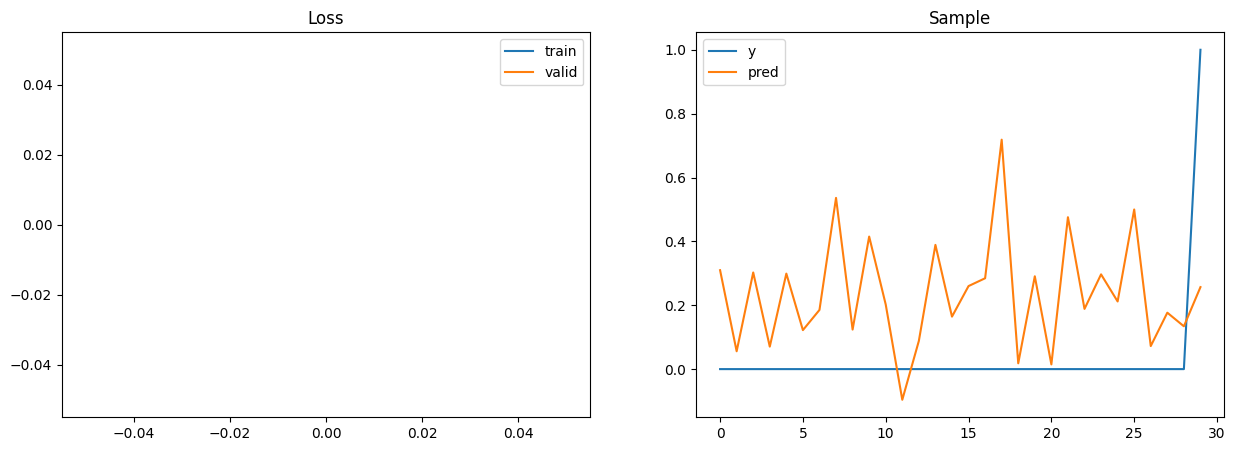

 0:0/2586 mean_train_loss: 0.012974460422992707 -- mean_val_loss: 0sales_embedding.shape torch.Size([32, 277, 512])
x.shape torch.Size([32, 277, 512])
src_key_padding_mask.shape torch.Size([32, 277])
x.shape torch.Size([32, 277, 512])
x.shape torch.Size([32, 277, 512])
src_key_padding_mask.shape torch.Size([32, 277])
x.shape torch.Size([32, 277, 512])
x.shape torch.Size([32, 277, 512])
src_key_padding_mask.shape torch.Size([32, 277])
x.shape torch.Size([32, 277, 512])
x.shape torch.Size([32, 277, 512])
src_key_padding_mask.shape torch.Size([32, 277])
x.shape torch.Size([32, 277, 512])
x.shape torch.Size([32, 277, 512])
src_key_padding_mask.shape torch.Size([32, 277])
x.shape torch.Size([32, 277, 512])
x.shape torch.Size([32, 277, 512])
src_key_padding_mask.shape torch.Size([32, 277])
x.shape torch.Size([32, 277, 512])
encoding.shape torch.Size([32, 277, 512])
 0:1/2586 mean_train_loss: 1.1095225848257542 -- mean_val_loss: 0sales_embedding.shape torch.Size([32, 254, 512])
x.shape torch.

KeyboardInterrupt: 

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

def plot_sample(y, pred):
    # Plot sample
    clear_output(wait=True)
    y_sample = y[-1]
    pred_sample = pred[-1].detach().cpu()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(y_sample, label="y")
    plt.plot(pred_sample, label="pred")
    plt.title("Sample")
    plt.legend()
    plt.show()

def train(epoch, val_loss, train_loss_li, val_loss_li):
    model.train()
    total_len = len(train_dataloader)
    loss_li = []
    for n, data in enumerate(train_dataloader):
        sales, img, img_tensor, year, month, week, day, dayofweek, y = data
        
        # Train
        optimizer.zero_grad()
        pred, attn_weight = model(sales.to(device), img_tensor.to(device), year.to(device), month.to(device), week.to(device), day.to(device), dayofweek.to(device))
        pred = pred.squeeze()

        # plot sample
        if not verbose: 
            if n % 10 == 0: plot_sample(np.expm1(y), np.expm1(pred.detach().cpu()))
        loss = loss_fn(pred, y.to(device))
        loss.backward()
        optimizer.step()

        # Report
        loss_li.append(loss.item())
        mean_loss = np.mean(loss_li[-10:]) / 10
        if not verbose: print(f"\r {epoch}:{n}/{total_len} mean_train_loss: {mean_loss} -- mean_val_loss: {val_loss}", end="")

    print()
    return mean_loss

def val(epoch):
    model.eval()
    total_len = len(valid_dataloader)
    total_loss = 0
    for n, data in enumerate(valid_dataloader):
        sales, img, img_tensor, season, category, extra, year, month, y = data
        
        # Pred
        with torch.no_grad():
            pred, attn_weight = model(sales.to(device), img_tensor.to(device), img_mask.to(device), season.to(device), category.to(device), extra.to(device), year.to(device), month.to(device))
            pred = pred.squeeze()
            loss = loss_fn(pred, y.to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            print(f"\r {epoch}:{n}/{total_len} mean_val_loss: {mean_loss}", end="")

    print()
    return mean_loss
 
epoch = 5
train_loss_li, val_loss_li = [0], [0]
val_loss = 0

for e in range(epoch):
    train_loss = train(e, val_loss, train_loss_li, val_loss_li) # Train
    # val_loss = val(e)

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    torch.save(model.state_dict(), f"model_{np.mean(train_loss)}_{np.mean(val_loss)}.pth")

In [9]:
torch.save(model.state_dict(), f"model.pth")

In [51]:
from transformers import AutoImageProcessor, SwinModel, SwinForImageClassification, ViTModel, ViTForImageClassification
import matplotlib.cm as cm
from gradcam import GradCAM
from gradcam.utils import visualize_cam
import cv2
import time

# model.load_state_dict(torch.load("model.pth"))
# model.eval()
# model.train()

# for data in valid_dataloader:
for data in train_dataloader:
    sales, img, img_tensor, year, month, week, day, dayofweek, y = data
    with torch.no_grad():
        pred, attn_weight = model(sales.to(device), img_tensor.to(device), year.to(device), month.to(device), week.to(device), day.to(device), dayofweek.to(device))
        # loss = loss_fn(pred, y.to(device)).item()
        break

sales_embedding.shape torch.Size([32, 429, 512])
encoding.shape torch.Size([32, 429, 512])


### Eval

In [ ]:
attn_weight[0].shape

torch.Size([32, 12, 197, 197])

In [53]:
def get_attention_map(img, att_mat, get_mask=False):
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)
    print("att_mat.shape:", att_mat.shape)
    # att_mat = torch.max(att_mat, dim=1).values

    # To account for residual connections, we add an identity matrix to the attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    print("joint_attentions.shape:", joint_attentions.shape)
    v = joint_attentions[-1]
    print("v.shape:", v.shape)
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    print("grid_size.shape:", grid_size)
    print(v[0, 1:].shape)
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    # mask = v[0].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def get_attention_map(img, att_mat, get_mask=False):
    # Average the attention weights across all heads.
    att_mat = [torch.mean(i, dim=1) for i in att_mat]
    att_mat = torch.concat(att_mat, dim=0)
    
    # att_mat = torch.max(att_mat, dim=1).values

    # To account for residual connections, we add an identity matrix to the attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    print("joint_attentions.shape:", joint_attentions.shape)
    v = joint_attentions[-1]
    print("v.shape:", v.shape)
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    print("grid_size.shape:", grid_size)
    print(v[0, 1:].shape)
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    # mask = v[0].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return result

def plot_attention_map(original_img, att_map, loss):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 5))
    ax1.set_title('Original')
    ax2.set_title(loss)
    _ = ax1.imshow(original_img)
    _ = ax2.imshow(att_map, cmap = cm.gray)

In [56]:
from transformers import AutoImageProcessor, SwinModel, SwinForImageClassification, ViTModel, ViTForImageClassification
import matplotlib.cm as cm
from gradcam import GradCAM
from gradcam.utils import visualize_cam
import cv2
import time

model.load_state_dict(torch.load("model.pth"))
# model.eval()
model.train()

# for data in valid_dataloader:
for data in train_dataloader:
    sales, img, img_tensor, year, month, week, day, dayofweek, y = data
    with torch.no_grad():
        pred, attn_weight = model(sales.to(device), img_tensor.to(device), year.to(device), month.to(device), week.to(device), day.to(device), dayofweek.to(device))
        res = get_attention_map(img, tuple(i.detach().cpu() for i in attn_weight), get_mask=True)
        plot_attention_map(img[0], res, loss)
        # get_myattention(attn_weight, img_)
        plt.show()
        input()
        clear_output(wait=True)
        time.sleep(0.5)

sales_embedding.shape torch.Size([32, 375, 512])
x.shape torch.Size([32, 375, 512])
src_key_padding_mask.shape torch.Size([32, 375])
x.shape torch.Size([32, 375, 512])
x.shape torch.Size([32, 375, 512])
src_key_padding_mask.shape torch.Size([32, 375])
x.shape torch.Size([32, 375, 512])
x.shape torch.Size([32, 375, 512])
src_key_padding_mask.shape torch.Size([32, 375])
x.shape torch.Size([32, 375, 512])
x.shape torch.Size([32, 375, 512])
src_key_padding_mask.shape torch.Size([32, 375])
x.shape torch.Size([32, 375, 512])
x.shape torch.Size([32, 375, 512])
src_key_padding_mask.shape torch.Size([32, 375])
x.shape torch.Size([32, 375, 512])
x.shape torch.Size([32, 375, 512])
src_key_padding_mask.shape torch.Size([32, 375])
x.shape torch.Size([32, 375, 512])
encoding.shape torch.Size([32, 375, 512])
joint_attentions.shape: torch.Size([384, 197, 197])
v.shape: torch.Size([197, 197])
grid_size.shape: 14
torch.Size([196])


AttributeError: 'list' object has no attribute 'size'